# The Xgboost library

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from datetime import datetime
import Methods as models
import Predictors as predictors
import stock_tools as st
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)

/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


This is the file which gives the methodology behind the use of xgboost. xgboost can be found at https://xgboost.readthedocs.io . Xgboost is a library for gradient boosting decision trees. I decided to use it here as we would like to know what components are essential in making a prediction. It also makes it easy to optimize model parameters and cross validate the model.

In [3]:
# Create a template with the available variables
interest = 'SPY'
start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2010-12-31', '%Y-%m-%d')

# Get the data and correct for fluctuations
data = st.get_data(start_date,end_date,from_file=True)
corr_data = st.ohlc_adj(data)
# Create a predictors class which we will base our decisions from
pred = predictors.Predictors(corr_data)

# The data is far too noisy to make accurate predictions.
# We apply a 5 day exponential rolling filter. This should preserve
# shape and reduce noise.
pred.e_filter(5)

### Make testing and training data for feature extraction.

In [4]:
imp = pred.props
i = 252*2
ndays = 252*2
forward_look = 0
ind = int(np.round(ndays * 0.8))
temp = ((1 - pred.data.Close.shift(1).div(pred.data.Close)) > 0)*1
X_TRAIN = imp.ix[(i - ndays):(i - ndays + ind)]
Y_TRAIN = temp.ix[imp.ix[(i - ndays+forward_look):(i - ndays + ind+forward_look)].index]
X_TEST = imp.ix[(i - ndays + ind):i]
Y_TEST = temp.ix[imp.ix[(i - ndays + ind+forward_look):(i+forward_look)].index]

Now the starting parameters for the are not optimised. First we optimise the decision trees main parameters. The depth and the minimum child weight.

In [5]:
cv_params = {'max_depth': [3,5,7,9,11], 'min_child_weight': [1,3,5,7,9]}
# Our other parameters. Note the binary logistic objective as we want to determine rise or fall.
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic'}
# Make the optimizer
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
# Optimise on the training data
optimized_GBM.fit(X_TRAIN, Y_TRAIN)
# Possible parameter combinations
print(optimized_GBM.grid_scores_)

[mean: 0.94541, std: 0.01532, params: {'min_child_weight': 1, 'max_depth': 3}, mean: 0.94293, std: 0.01311, params: {'min_child_weight': 3, 'max_depth': 3}, mean: 0.93797, std: 0.01403, params: {'min_child_weight': 5, 'max_depth': 3}, mean: 0.93797, std: 0.00830, params: {'min_child_weight': 7, 'max_depth': 3}, mean: 0.93548, std: 0.01678, params: {'min_child_weight': 9, 'max_depth': 3}, mean: 0.94045, std: 0.01858, params: {'min_child_weight': 1, 'max_depth': 5}, mean: 0.93797, std: 0.01159, params: {'min_child_weight': 3, 'max_depth': 5}, mean: 0.93797, std: 0.01403, params: {'min_child_weight': 5, 'max_depth': 5}, mean: 0.93797, std: 0.00830, params: {'min_child_weight': 7, 'max_depth': 5}, mean: 0.93548, std: 0.01678, params: {'min_child_weight': 9, 'max_depth': 5}, mean: 0.93548, std: 0.00979, params: {'min_child_weight': 1, 'max_depth': 7}, mean: 0.93797, std: 0.01159, params: {'min_child_weight': 3, 'max_depth': 7}, mean: 0.93797, std: 0.01403, params: {'min_child_weight': 5, 'm

Make a dictionary of the best parameters.

In [6]:
best = sorted(optimized_GBM.grid_scores_, key=lambda x: (x[1], -np.std(x[2]), -x.parameters['max_depth']))[
    -1].parameters

We see that a max depth of 3 and min_child_weight of 7 is the best. Now optimise the learning rate and subsample.

In [7]:
cv_params = {'learning_rate': [0.1, 0.01, 0.005], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed': 0, 'colsample_bytree': 0.8,
                      'objective': 'binary:logistic', 'max_depth': best["max_depth"],
                      'min_child_weight': best["min_child_weight"]}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_TRAIN, Y_TRAIN)

# Add these parameters to the dictionary.
best = {**best, **sorted(optimized_GBM.grid_scores_, key=lambda x: (x[1], -np.std(x[2]), x.parameters['subsample']))[
    -1].parameters}
# Create a cross validation matrix
xgdmat = xgb.DMatrix(X_TRAIN, Y_TRAIN)
# We see that a subsample of 0.9 and learning rate of 0.005 is the best

our_params = {'eta': best["learning_rate"], 'seed': 0, 'subsample': best["subsample"], 'colsample_bytree': 0.8,
              'objective': 'binary:logistic', 'max_depth': best["max_depth"],
              'min_child_weight': best["min_child_weight"]}

This is where we do the cross validation. We DONT want to overfit!

In [8]:
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 4000, nfold = 10,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error
print(cv_xgb.tail(5))

    test-error-mean  test-error-std  train-error-mean  train-error-std
13           0.0450        0.029155          0.024722         0.004383
14           0.0475        0.028395          0.024167         0.003938
15           0.0450        0.029155          0.023333         0.003968
16           0.0450        0.036742          0.023611         0.003977
17           0.0400        0.032016          0.021389         0.002500


We now have a good model for our data.

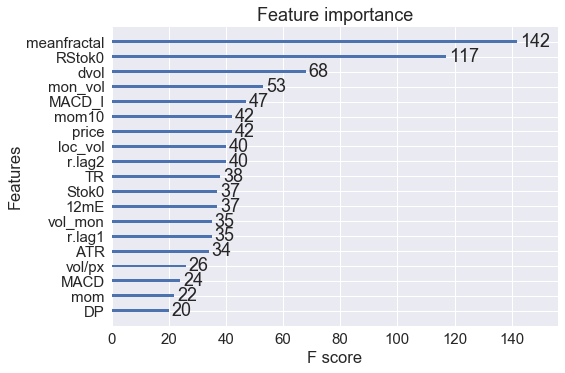

In [9]:
our_params = {'eta': best["learning_rate"], 'seed': 0, 'subsample': best["subsample"], 'colsample_bytree': 0.8,
              'objective': 'binary:logistic', 'max_depth': best["max_depth"],
              'min_child_weight': best["min_child_weight"]}
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

# Now we check out the feature importance
# We find that RStok0, meanfractal, mom and MACD_I and dvol are important.
xgb.plot_importance(final_gb)
plt.show()

Now try the test data

In [10]:
testdmat = xgb.DMatrix(X_TEST)
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
print(y_pred)
predicted = y_pred
predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
X_TEST["REAL"] = Y_TEST
X_TEST["PRED"] = predicted
ret = accuracy_score(predicted, Y_TEST), 1-accuracy_score(predicted, Y_TEST)
print("Accuracy is %s" % ret[0])


[  9.99068320e-01   9.99639750e-01   9.99833107e-01   9.99764860e-01
   9.97895360e-01   9.99837995e-01   9.99702990e-01   3.78994495e-02
   8.73265982e-01   1.23809623e-02   7.60990847e-03   3.03097926e-02
   1.19838798e-02   1.87603186e-03   1.92730152e-03   1.01065123e-03
   3.70688170e-01   9.83922243e-01   9.98689592e-01   9.99633908e-01
   5.59703971e-04   2.79552746e-03   9.65173781e-01   3.52277560e-03
   1.82504300e-03   5.44040231e-03   4.88378992e-03   9.82798403e-04
   6.20118459e-04   7.07674548e-02   9.99168754e-01   1.04168162e-03
   6.09948125e-04   9.99726713e-01   1.51516218e-03   4.54670342e-04
   1.44395663e-03   1.34881039e-03   9.76961222e-04   1.33470399e-03
   5.25832295e-01   9.99676108e-01   9.99733388e-01   9.99614716e-01
   9.98852015e-01   9.98829067e-01   9.99694586e-01   9.99731004e-01
   9.99506593e-01   9.99290109e-01   4.98613030e-01   9.99090791e-01
   8.73882413e-01   1.04413323e-01   9.81959939e-01   1.18606247e-01
   9.99621630e-01   9.99812424e-01

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


From this we just make a scatter plot so we can visualise the spacial separation

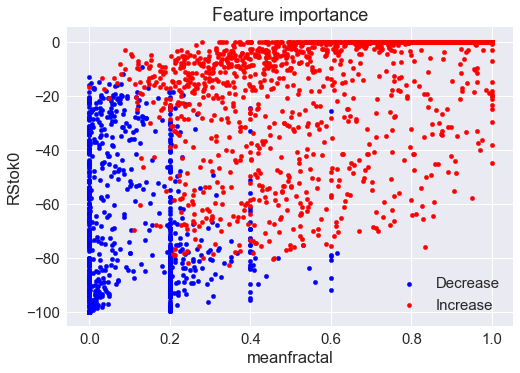

In [11]:
m = []
m.append(models.ML(pred.props))
m[0].pred.PHH = ((1 - pred.data.Close.shift(1).div(pred.data.Close)) > 0)*1
ax = pred.props.ix[m[0].pred.PHH == 0].plot.scatter(x='meanfractal', y='RStok0', label='Decrease',color="b")
a2 = pred.props.ix[m[0].pred.PHH == 1].plot.scatter(x='meanfractal', y='RStok0', label='Increase',color="r",ax=ax)
ax.set_title("Feature importance")
plt.show()